In [4]:
from scipy.io import loadmat
import numpy as np
import numpy.ma as ma
import utilities_figures as ufig
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [1]:
patient_id = 'ID07'
id_ = patient_id
h_string = '31to39h'
h_offset = 31  # hours
h_range = 9
vmax = 40
ax0_ylim = (0, 100)
ax1_ylim = (0.028, 0.04)
ax2_ylim = (0.004, 0.012)
ax3_ylim = (0.13, 0.27)

C:\Users\janse\Anaconda3\shy\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
# ID07 RNN
patient_id = 'ID07'
h_string = '31to39h'
h_offset = 31  # hours
h_range = 9
vmax = 40
ax1_ylim = (0, 150)
ax2_ylim = None
ax3_ylim = None
ax4_ylim = None

In [41]:
patient_id = 'ID08'
id_ = patient_id
h_string = '57to65h'
h_offset = 57  # hours
h_range = 9
vmax = 800
ax0_ylim = (0, 1000)
ax1_ylim = (0.035, 0.045)
ax2_ylim = (0.0043, 0.007)
ax3_ylim = (0.145, 0.23)

In [2]:
patient_id = 'ID11'
id_ = patient_id + 'a'
h_string = '59to65h'
h_offset = 59  # hours
h_range = 7
vmax = 300
ax0_ylim = (0, 900)
ax1_ylim = (0.063, 0.078)
ax2_ylim = (0.0035, 0.0062)
ax3_ylim = (0.33, 0.4)

In [5]:
patient_id = 'ID11'
id_ = patient_id + 'b'
h_string = '129to137h'
h_offset = 129  # hours
h_range = 9
vmax = 300
ax0_ylim = (0, 1500)
ax1_ylim = (0.06, 0.08)
ax2_ylim = (0.003, 0.0068)
ax3_ylim = (0.33, 0.42)

In [6]:
data_mat = loadmat('../data/' + patient_id + '_' + h_string + '.mat')
info = loadmat('../data/' + patient_id + '_info.mat')
fs = float(info['fs'])
data_np = data_mat['EEG']
data_list = [data_np[i, :] for i in range(data_np.shape[0])]

print(data_list[1].shape)

# Parameters
channel_idx = 0
sw_band = (0.5, 4)
nperseg = int(6*60*fs) #int(20*fs)
noverlap = 0 #int(10*fs)
#t_stamps_0 = [(32, 10), (35, 10), (38, 15)]  # ([h], [min])
#t_stamps_0 = [(58, 0), (60, 2), (64, 40)]  # ([h], [min])
#t_stamps_0 = [(60, 5), (62, 10), (64, 55)]  # ([h], [min])
t_stamps_0 = [(129, 45), (133, 36), (136, 30)]  # ([h], [min])
duration = 5  # [min]

t_stamps = []
for i, val in enumerate(t_stamps_0):
    t_stamps.append(val[0] + val[1]/60)

(33177600,)


In [7]:
data = data_list[channel_idx]

# Get spectral density
f, t, Sxx = signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap, scaling='density')

# Extract slow wave band with tukey window
Sxx_band = Sxx[int(sw_band[0] * Sxx.shape[0] / f[-1]):int(sw_band[1] * Sxx.shape[0] / f[-1]), :]
tukey_window_band = np.tile(signal.tukey(Sxx_band.shape[0]), (Sxx_band.shape[1], 1)).T
Sxx_band_tukey = np.multiply(Sxx_band,  tukey_window_band)

# Compute average band power
swa = np.mean(Sxx_band_tukey, axis=0)

#plt.figure(figsize=(10,5))
#plt.pcolormesh(t, f, Sxx, vmax=vmax, cmap='viridis')
#plt.ylim(0, 30)

In [8]:
corrmean = np.load('../data/corrmean_' + patient_id + '_' + h_string + '_all.npy')
#corrmean = np.mean(corrmean, axis=1)

#pre = 'allpos'
pre = 'SLP_allpos'


ids = []
for h_ in range(h_range):
    for m in range(10):  # 30
        h = h_ + h_offset
        m = 6 * m  # 2

        zero = ''
        if m < 10:
            zero = '0'

        t_string = str(h) + 'h' + zero + str(m) + 'm'
        if patient_id == 'ID11':
            if h_offset == 59:
                additional = 'a'
            else:
                additional = 'b'
        else:
            additional = ''
        ids.append(pre + '_' + patient_id + additional + '_' + t_string)

mean_abs, mse, mae, corr = ufig.mean_weights(ids, output=True)
t_results = np.linspace(h_offset, h_offset + h_range, len(mean_abs))


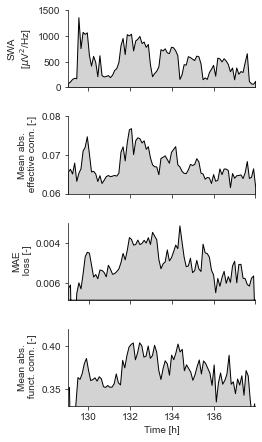

In [9]:
n_subplots = 4
    
fig = plt.figure(figsize=(4, 6.5))
sns.set_style('ticks')
t_hours = t/60/60 + h_offset
ax = [[], [], [], []]
labels = ['SWA\n [$\mu$V$^2$/Hz]', 'Mean abs.\n effective conn. [-]', 'MAE\n loss [-]', 'Mean abs.\n funct. conn. [-]']

ax[0] = fig.add_subplot(n_subplots, 1, 1)
plt.fill_between(t_hours, swa, 0, lw=1, color='lightgrey', label='unfiltered', edgecolor='black')  # 'darkgrey'
#smooth = signal.savgol_filter(swa, window_length=101, polyorder=3)
#plt.plot(t_hours, smooth, c='black', lw=1, label='filtered')
#plt.legend(loc='upper right', frameon=False)
ax[0].set_xlim(t_hours[0], t_hours[-1])
if ax0_ylim is not None:
    ax[0].set_ylim(ax0_ylim)
ylim = ax[0].get_ylim()
ax[0].set_ylabel(labels[0])
ax[0].set_ylim(ylim)

#ax[0].set_xlabel('Time [h]')

ax[1] = fig.add_subplot(n_subplots, 1, 2)
plt.fill_between(t_results, mean_abs, 0, color='lightgrey', lw=1, edgecolor='black')
ax[1].set_xlim(t_results[0], t_results[-1])
if ax1_ylim is not None:
    ax[1].set_ylim(ax1_ylim)
ax[1].set_ylabel(labels[1])
#ax[1].set_xlabel('Time [h]')

ax[2] = fig.add_subplot(n_subplots, 1, 3)
plt.fill_between(t_results, mae, ax2_ylim[1], color='lightgrey', lw=1, edgecolor='black')
ax[2].set_xlim(t_results[0], t_results[-1])
if ax2_ylim is not None:
    ax[2].set_ylim(ax2_ylim)
ax[2].invert_yaxis()
ax[2].set_ylabel(labels[2])

ax[3] = fig.add_subplot(n_subplots, 1, 4)
t_corr = np.linspace(t_hours[0], t_hours[-1], len(corrmean))
upper_ylim = np.max(corrmean)+np.max(corrmean)/10
lower_ylim = np.min(corrmean)-np.min(corrmean)/10
#corr_arr = signal.resample(corrmean, len(mean_abs))
plt.fill_between(t_results, corrmean, 0, color='lightgrey', lw=1, edgecolor='black')
ax[3].set_xlim(t_hours[0], t_hours[-1])
if ax3_ylim is not None:
    ax[3].set_ylim(ax3_ylim)
else:
    ax[3].set_ylim(lower_ylim, upper_ylim)
ax[3].set_ylabel(labels[3])
ax[3].set_xlabel('Time [h]')

for i, a in enumerate(ax):
    a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)
    #a.set_xticks(np.arange(130, 140, 2))
    if i < 3:
        plt.setp(a.get_xticklabels(), visible=False)

plt.tight_layout(pad=2)
plt.savefig('figures/fig_Ch3_SleepSegment_' + id_ + '.png', dpi=300)
plt.show()

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x173217ec808>])

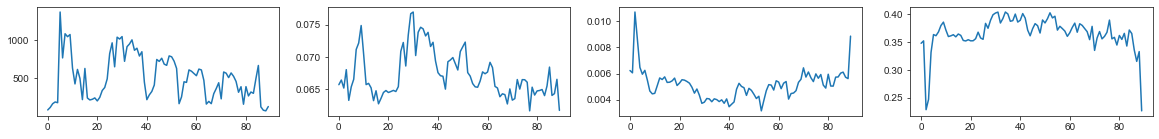

In [10]:
smooth_rs = swa.copy() #signal.resample(smooth, len(mean_abs))
mean_abs_arr = np.asarray(mean_abs)
mae_arr = np.asarray(mae)
corr_arr = corrmean.copy()
plt.figure(figsize=(20, 2))
plt.subplot(1,4,1), plt.plot(smooth_rs)
plt.subplot(1,4,2), plt.plot(mean_abs_arr)
plt.subplot(1,4,3), plt.plot(mae_arr)
plt.subplot(1,4,4), plt.plot(corr_arr)


(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x15235b75748>])

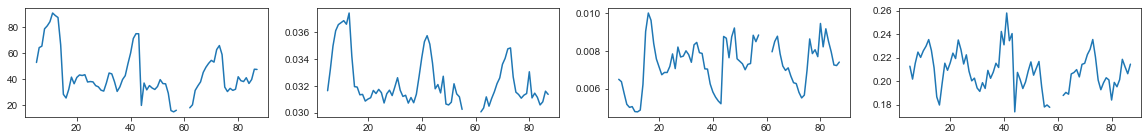

In [36]:
# ID07 Artefact removal
mean_abs_arr[:5] = np.nan
mae_arr[:5] = np.nan
smooth_rs[:5] = np.nan
corr_arr[:5] = np.nan
mean_abs_arr[56:62] = np.nan
mae_arr[58:62] = np.nan
smooth_rs[58:62] = np.nan
corr_arr[58:62] = np.nan
mean_abs_arr[88:] = np.nan
mae_arr[88:] = np.nan
smooth_rs[88:] = np.nan
corr_arr[88:] = np.nan

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x19d5c249bc8>])

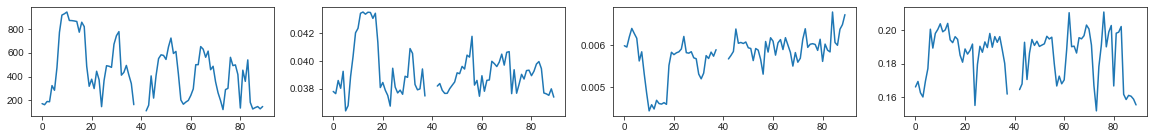

In [47]:
# ID08 Artefact removal
mean_abs_arr[38:42] = np.nan
mae_arr[38:42] = np.nan
smooth_rs[38:42] = np.nan
corr_arr[38:42] = np.nan
plt.figure(figsize=(20, 2))
plt.subplot(1,4,1), plt.plot(smooth_rs)
plt.subplot(1,4,2), plt.plot(mean_abs_arr)
plt.subplot(1,4,3), plt.plot(mae_arr)
plt.subplot(1,4,4), plt.plot(corr_arr)

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x2a35daaf148>])

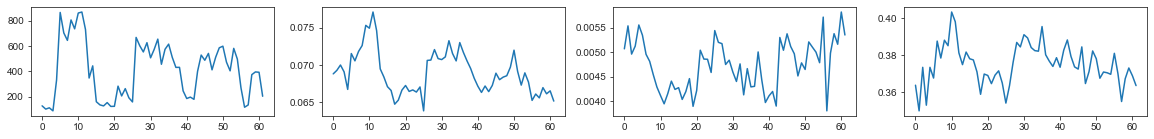

In [8]:
# ID11a Artefact removal
mean_abs_arr[62:] = np.nan
mae_arr[62:] = np.nan
smooth_rs[62:] = np.nan
corr_arr[62:] = np.nan
plt.figure(figsize=(20, 2))
plt.subplot(1,4,1), plt.plot(smooth_rs)
plt.subplot(1,4,2), plt.plot(mean_abs_arr)
plt.subplot(1,4,3), plt.plot(mae_arr)
plt.subplot(1,4,4), plt.plot(corr_arr)

(<AxesSubplot:>, [<matplotlib.lines.Line2D at 0x17321957208>])

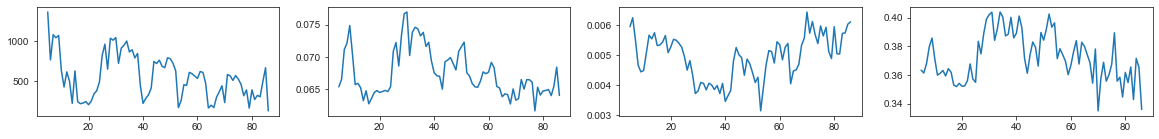

In [11]:
# ID11b
mean_abs_arr[:5] = np.nan
mae_arr[:5] = np.nan
smooth_rs[:5] = np.nan
corr_arr[:5] = np.nan
mean_abs_arr[87:] = np.nan
mae_arr[87:] = np.nan
smooth_rs[87:] = np.nan
corr_arr[87:] = np.nan
plt.figure(figsize=(20, 2))
plt.subplot(1,4,1), plt.plot(smooth_rs)
plt.subplot(1,4,2), plt.plot(mean_abs_arr)
plt.subplot(1,4,3), plt.plot(mae_arr)
plt.subplot(1,4,4), plt.plot(corr_arr)

SWA: 0.8045229563465911
MAE: -0.6110671792977842
CORR: 0.6860866278009672


<Figure size 110.16x108 with 0 Axes>

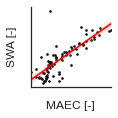

<Figure size 110.16x108 with 0 Axes>

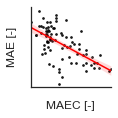

<Figure size 110.16x108 with 0 Axes>

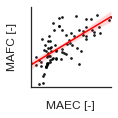

In [12]:
c_swa = ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(smooth_rs))[0, 1]
c_mae = ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(mae_arr))[0, 1]
c_corr = ma.corrcoef(ma.masked_invalid(mean_abs_arr), ma.masked_invalid(corr_arr))[0, 1]
np.save('../data/c_swa_' + id_ + '.npy', c_swa)
np.save('../data/c_mae_' + id_ + '.npy', c_mae)
np.save('../data/c_corr_' + id_ + '.npy', c_corr)
print('SWA: ' + str(c_swa))
print('MAE: ' + str(c_mae))
print('CORR: ' + str(c_corr))

df = pd.DataFrame()
df['swa'] = smooth_rs
df['maec'] = mean_abs_arr
df['mae'] = mae_arr
df['mafc'] = corr_arr

sns.set(rc={'figure.figsize':(1.53, 1.5)})
plt.figure()
sns.set_style('white')
sns.lmplot(x='maec', y='swa', data=df, line_kws={'color': 'red', 'lw': 1.5}, scatter_kws={'color': 'black', 's': 3}, height=1.8)
plt.xlabel('MAEC [-]'), plt.ylabel('SWA [-]')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.set_yticklabels([]), ax.set_xticklabels([])
plt.tight_layout()
plt.savefig('figures/fig_Ch3_SleepSegment_r_w_swa.png', dpi=200)

plt.figure()
sns.lmplot(x='maec', y='mae', data=df, line_kws={'color': 'red', 'lw': 1.5}, scatter_kws={'color': 'black', 's': 3}, height=1.8)
plt.xlabel('MAEC [-]'), plt.ylabel('MAE [-]')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.set_yticklabels([]), ax.set_xticklabels([])
plt.tight_layout()
plt.savefig('figures/fig_Ch3_SleepSegment_r_w_mae.png', dpi=200)

plt.figure()
sns.lmplot(x='maec', y='mafc', data=df, line_kws={'color': 'red', 'lw': 1.5}, scatter_kws={'color': 'black', 's': 3}, height=1.8)
plt.xlabel('MAEC [-]'), plt.ylabel('MAFC [-]')
ax = plt.gca()
ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False)
ax.set_yticklabels([]), ax.set_xticklabels([])
plt.tight_layout()
plt.savefig('figures/fig_Ch3_SleepSegment_r_w_corr.png', dpi=200)




In [11]:
t_stamps = [67, 256, 442]
for i, val in enumerate(t_stamps):
    val_hour = h_offset+(val/60)
    val_min = (val_hour - np.floor(val_hour)) * 60
    print(str(i) + ' hour: ' + str(np.floor(val_hour)) + ' | min: ' + str(val_min))

0 hour: 60.0 | min: 7.000000000000028
1 hour: 63.0 | min: 15.999999999999943
2 hour: 66.0 | min: 21.999999999999602


In [13]:
ids_ = ['ID07', 'ID08', 'ID11a', 'ID11b']
c_swa = []
c_mae = []
c_corr = []
for i, val in enumerate(ids_):
    c_swa.append(np.load('../data/c_swa_' + val + '.npy'))
    c_mae.append(np.abs(np.load('../data/c_mae_' + val + '.npy')))
    c_corr.append(np.load('../data/c_corr_' + val + '.npy'))

C:\Users\janse\Anaconda3\shy\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


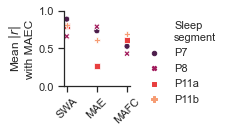

In [19]:
df = pd.DataFrame()
x_num = ['SWA', 'MAE', 'MAFC']
y_num = [c_swa, c_mae, c_corr]
for i in range(3):
    df_temp = pd.DataFrame()
    df_temp['pos'] = ['P7', 'P8', 'P11a', 'P11b']
    df_temp['y'] = [x_num[i] for _ in range(len(c_swa))]
    df_temp['x'] = y_num[i]
    df = df.append(df_temp, ignore_index=True)
plt.figure(figsize=(3.5, 2))
sns.set_style('ticks')
sb = sns.scatterplot(x='y', y='x', data=df, hue='pos', style='pos', palette='rocket')#, color='lightgrey', errcolor='black', edgecolor='black')
lg = plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
lg.texts[0].set_text('Sleep\nsegment')
for i in range(4):
    lg.legendHandles[i]._sizes = [20]
plt.ylabel('Mean $|r|$\nwith MAEC')
plt.ylim(0, 1)
plt.xlabel('')
sb.set_xticklabels(x_num, rotation=45)
sb.spines['right'].set_visible(False), sb.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('figures/fig_Ch3_SleepSegments_r.png', dpi=200)

In [26]:
c_swa = np.asarray(c_swa).flatten()
c_mae = np.asarray(c_mae).flatten()
c_corr = np.asarray(c_corr).flatten()

c_swa = c_swa / c_swa * 100
c_mae = c_mae / c_swa
c_corr = c_corr / c_swa

c_swa = c_swa.tolist()
c_mae = c_mae.tolist()
c_corr = c_corr.tolist()

In [35]:
c_mae

array([0.73391586, 0.78780908, 0.26668067, 0.61106718])

In [36]:
c_mae / c_swa

array([0.82614099, 1.19402951, 0.33632221, 0.75953977])

In [38]:
(c_mae / c_swa * 100).tolist()

[82.61409912163663, 119.40295075262233, 33.63222098850683, 75.95397676067486]

In [39]:
print(c_swa)
print(c_mae)
print(c_corr)

[0.88836635 0.65979029 0.79293209 0.80452296]
[0.73391586 0.78780908 0.26668067 0.61106718]
[0.52851763 0.43042774 0.61355016 0.68608663]


In [35]:
sns.cubehelix_palette(start=0, rot=0)

[[0.8434421341945405, 0.8361549655055748, 0.9510579822529797],
 [0.6975595088658209, 0.6857229411457132, 0.87236022059208],
 [0.5540464159938485, 0.5399510557477893, 0.762204647443291],
 [0.41679151403306425, 0.402696153787005, 0.6249497454825068],
 [0.2779516657285659, 0.26611509800845823, 0.452752377454825],
 [0.14148134988081507, 0.13419418119184928, 0.2490971979392541]]